In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

pd.options.display.max_rows = 100

In [22]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("trn.csv")
tst = pd.read_csv("tst.csv")
tr = pd.read_csv("tr.csv")
tps = pd.read_csv("tr_types.csv", sep=";")
cds = pd.read_csv("tr_cds.csv", sep=";")

In [3]:
print(df.shape)
df.head()

(8400, 2)


,customer_id,gender
0,10928546,1
1,69348468,1
2,61009479,0
3,74045822,0
4,27979606,1


In [4]:
print(tr.shape)
tr.head()

(6849346, 6)


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN


In [5]:
df = tr.merge(df, on="customer_id", how="outer")

In [6]:
df = df.drop(["term_id"], axis=1)

In [7]:
# gender:NaN => rows from test
df.sample(10)

,customer_id,tr_datetime,mcc_code,tr_type,amount,gender
5241344,63929380,87 15:35:40,6011,2010,-22459.16,0.0
6158231,23910067,318 12:06:02,5977,1010,-3177.97,0.0
5367897,8365381,343 00:00:00,5411,1110,-7523.82,NaN
5139803,86176665,70 19:34:21,6011,7010,89836.63,NaN
5377117,85572010,418 00:00:00,6012,6110,280739.47,NaN
3553220,47924325,77 00:00:00,5411,1110,-15031.91,0.0
4710040,64849998,450 14:18:06,5499,1010,-12221.60,0.0
4532905,39078187,290 07:10:45,6011,2010,-44918.32,NaN
4408227,3684270,130 08:06:12,4814,1030,-2245.92,0.0
2418941,25252032,55 08:13:00,5411,1010,-8480.58,NaN


In [8]:
# FE

In [9]:
## Frequency (independently of datetime)

In [10]:
def frequencies_ratio(df, key_column):
    def get_frequencies(gender):
        return (
            df[df.gender == gender][["gender", key_column]].groupby(key_column).count()
        )

    frequencies = get_frequencies(gender=1).sort_values(by="gender", ascending=False)
    frequencies = frequencies.merge(get_frequencies(gender=0), on=key_column)
    c = df[df.gender == 0].shape[0] / df[df.gender == 1].shape[0]
    frequencies[key_column + "_1to0_ratio"] = (
        c * frequencies.gender_x / frequencies.gender_y
    ).round(3)
    return frequencies.drop(["gender_x", "gender_y"], axis=1)

In [11]:
df = df.merge(frequencies_ratio(df, "mcc_code"), on="mcc_code", how="outer")
df = df.merge(frequencies_ratio(df, "tr_type"), on="tr_type", how="outer")

In [13]:
# hardcode (better to rewrite)


def frequencies2(df):
    tmp = pd.DataFrame(
        df[df.mcc_code_1to0_ratio > 2].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["mcc_r2"]
    df = df.merge(tmp, on="customer_id", how="outer")
    tmp = pd.DataFrame(
        df[df.mcc_code_1to0_ratio < 0.5].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["mcc_l2"]
    df = df.merge(tmp, on="customer_id", how="outer")
    tmp = pd.DataFrame(
        df[df.tr_type_1to0_ratio > 2].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["trt_r2"]
    df = df.merge(tmp, on="customer_id", how="outer")
    tmp = pd.DataFrame(
        df[df.tr_type_1to0_ratio < 0.5].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["trt_l2"]
    df = df.merge(tmp, on="customer_id", how="outer")
    return df


def frequencies3(df):
    tmp = pd.DataFrame(
        df[df.mcc_code_1to0_ratio > 3].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["mcc_r3"]
    df = df.merge(tmp, on="customer_id", how="outer")
    tmp = pd.DataFrame(
        df[df.mcc_code_1to0_ratio < 0.333].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["mcc_l3"]
    df = df.merge(tmp, on="customer_id", how="outer")
    tmp = pd.DataFrame(
        df[df.tr_type_1to0_ratio > 3].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["trt_r3"]
    df = df.merge(tmp, on="customer_id", how="outer")
    tmp = pd.DataFrame(
        df[df.tr_type_1to0_ratio < 0.333].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["trt_l3"]
    df = df.merge(tmp, on="customer_id", how="outer")
    return df

In [14]:
df = frequencies2(df)
df = frequencies3(df)

In [15]:
df = df.fillna({"mcc_r2": 1, "mcc_l2": 1, "trt_r2": 1, "trt_l2": 1})  # to prevent /0
df = df.fillna({"mcc_r3": 1, "mcc_l3": 1, "trt_r3": 1, "trt_l3": 1})  # to prevent /0

In [16]:
def preprocessing_ratios(df):
    def helper(x):
        a = x[0]
        b = x[1]
        ratio = a / b
        if (a < 5) & (b < 5):
            return 0
        elif ratio > 1:
            return ratio
        else:
            return -1.0 / ratio

    df["mcc2_factor"] = df[["mcc_r2", "mcc_l2"]].apply(helper, axis=1).round(3)
    df["trt2_factor"] = df[["trt_r2", "trt_l2"]].apply(helper, axis=1).round(3)
    return df

In [17]:
%%time
df = preprocessing_ratios(df)

CPU times: user 4min 28s, sys: 763 ms, total: 4min 29s
Wall time: 4min 29s


In [18]:
## Time features

In [19]:
def time_preprocessing(df):
    df["day"], df["time"] = df.tr_datetime.str.split(" ", 1).str
    df.time = pd.to_datetime(df.time, format="%H:%M:%S")
    df["hour"] = df.time.dt.round("H").dt.hour
    df.day = df.day.astype("int")

    # to prevent difference between 23 and 01
    k = 2 * np.pi / 24
    df["sin_hour"] = df["hour"].map(lambda x: np.sin(x * k))
    df["cos_hour"] = df["hour"].map(lambda x: np.cos(x * k))
    df.drop(["tr_datetime", "time"], axis=1, inplace=True)
    return df

In [20]:
df = time_preprocessing(df)

In [21]:
df.sample(20)

,customer_id,mcc_code,tr_type,amount,gender,mcc_code_1to0_ratio,tr_type_1to0_ratio,mcc_r2,mcc_l2,trt_r2,...,mcc_r3,mcc_l3,trt_r3,trt_l3,mcc_factor,trt_factor,day,hour,sin_hour,cos_hour
3495461,9819899,4814,1030,-3368.87,1.0,0.817,0.812,888.0,1.0,1.0,...,886.0,1.0,1.0,1.0,888.000,0.0,13,18,-1.000000e+00,-1.836970e-16
5228503,76762108,6011,2010,-11229.58,NaN,1.028,1.009,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,0.000,0.0,6,8,8.660254e-01,-5.000000e-01
3430904,71758343,4814,1030,-449.18,NaN,0.817,0.812,4.0,1.0,1.0,...,4.0,1.0,1.0,1.0,0.000,0.0,349,10,5.000000e-01,-8.660254e-01
2027477,10056437,5499,1010,-7299.23,1.0,0.986,0.975,140.0,53.0,36.0,...,100.0,18.0,1.0,1.0,2.642,36.0,345,16,-8.660254e-01,-5.000000e-01
6347148,5617583,6010,7070,44918.32,1.0,0.980,0.989,86.0,30.0,1.0,...,68.0,1.0,1.0,1.0,2.867,0.0,202,17,-9.659258e-01,-2.588190e-01
242587,29380413,6011,2010,-83098.88,1.0,1.028,1.009,2.0,5.0,1.0,...,1.0,1.0,1.0,1.0,-2.500,0.0,197,12,1.224647e-16,-1.000000e+00
4956815,39510825,4814,1030,-2245.92,0.0,0.817,0.812,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,0.000,0.0,406,18,-1.000000e+00,-1.836970e-16
6198447,85861930,6010,7070,7860.71,NaN,0.980,0.989,38.0,4.0,1.0,...,38.0,1.0,1.0,1.0,9.500,0.0,252,19,-9.659258e-01,2.588190e-01
6486445,14158276,4814,1030,-336.89,1.0,0.817,0.812,237.0,4.0,3.0,...,206.0,1.0,1.0,1.0,59.250,0.0,54,12,1.224647e-16,-1.000000e+00
898595,63145287,4829,4071,-224.59,0.0,1.007,1.122,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,0.000,0.0,452,12,1.224647e-16,-1.000000e+00


In [15]:
# aggregate->predict or predict->aggregate?

In [16]:
# Predictions ([predict]->[aggregate by mean] case)

In [24]:
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.02,
    "num_leaves": 80,
    "feature_fraction": 0.64,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "boosting_type": "gbdt",
}

In [25]:
def prepare_sample(df):
    df = df.dropna()
    X = df.drop(["gender", "customer_id"], axis=1, errors="ignore")
    y = df.gender
    return X, y

In [26]:
X_train, y_train = prepare_sample(df)

In [27]:
%%time
model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train)
# model = lgb.train(params, dtrain, verbose_eval=50)

CPU times: user 1min 40s, sys: 823 ms, total: 1min 41s
Wall time: 8.24 s


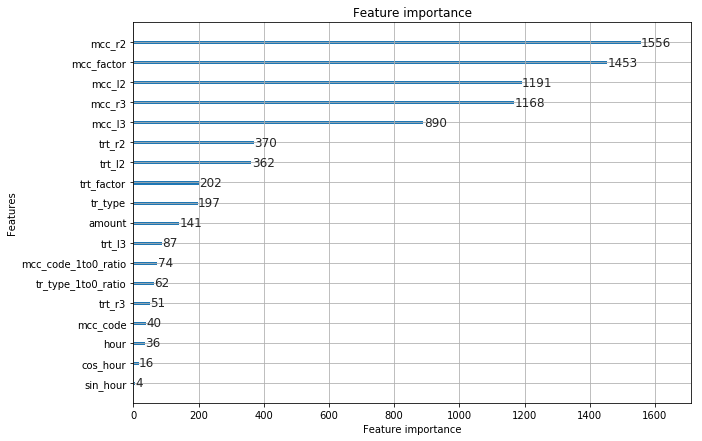

In [28]:
f, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.set(style="darkgrid")
lgb.plot_importance(model, ax=ax)

In [31]:
df_train = df.dropna()
df_train["gender_pred"] = model.predict_proba(X_train)[:, 1]

In [32]:
df_test = df.merge(tst, on="customer_id", how="inner")
X_test = df_test.drop(["gender", "customer_id", "probability"], axis=1, errors="ignore")
df_test["gender_pred"] = model.predict_proba(X_test)[:, 1]

In [33]:
# heuristic
def postprocessing(df):
    def helper(x):
        pred = x[0]
        mcc = x[1]
        trt = x[2]
        if mcc + trt > 10:
            return 1.0
        elif mcc + trt < -10:
            return 0.0
        else:
            return pred

    df["gender_pred_2"] = (
        df[["gender_pred", "mcc_factor", "trt_factor"]].apply(helper, axis=1).round(3)
    )
    return df

In [34]:
%%time
df_train = postprocessing(df_train)
df_test = postprocessing(df_test)

CPU times: user 2min 22s, sys: 550 ms, total: 2min 22s
Wall time: 2min 22s


In [43]:
df_train.sample(10)

,customer_id,mcc_code,tr_type,amount,gender,mcc_code_1to0_ratio,tr_type_1to0_ratio,mcc_r2,mcc_l2,trt_r2,...,trt_r3,trt_l3,mcc_factor,trt_factor,day,hour,sin_hour,cos_hour,gender_pred,gender_pred_2
2682082,80432221,4814,1030,-4491.83,1.0,0.817,0.812,87.0,32.0,1.0,...,1.0,1.0,2.719,-5.0,400,14,-0.500000,-0.866025,0.813011,0.813
2795188,21544548,5964,1200,-110186.20,0.0,0.466,1.418,1.0,419.0,1.0,...,1.0,1.0,-419.000,-31.0,393,0,0.000000,1.000000,0.094254,0.000
5643619,65311903,5411,1110,-7003.21,0.0,0.959,1.167,10.0,27.0,1.0,...,1.0,1.0,-2.700,0.0,244,14,-0.500000,-0.866025,0.176418,0.176
1670978,14104717,4814,1030,-14802.38,0.0,0.817,0.812,1.0,12.0,2.0,...,1.0,1.0,-12.000,0.0,250,9,0.707107,-0.707107,0.105215,0.000
3414207,86574143,5411,1110,-3818.06,1.0,0.959,1.167,37.0,18.0,1.0,...,1.0,1.0,2.056,0.0,414,0,0.000000,1.000000,0.712155,0.712
4584774,55035599,5411,1010,-6580.53,0.0,0.959,0.975,3.0,151.0,1.0,...,1.0,1.0,-50.333,-55.0,39,14,-0.500000,-0.866025,0.124100,0.000
6848783,72375056,6011,2010,-381805.68,0.0,1.028,1.009,1.0,1.0,1.0,...,1.0,1.0,0.000,0.0,399,15,-0.707107,-0.707107,0.448431,0.448
4046741,46637679,4814,1030,-6737.75,1.0,0.817,0.812,2.0,1.0,1.0,...,1.0,1.0,0.000,0.0,281,8,0.866025,-0.500000,0.400218,0.400
4258323,66499894,6010,7070,15474.36,0.0,0.980,0.989,1.0,112.0,1.0,...,1.0,1.0,-112.000,0.0,384,20,-0.866025,0.500000,0.120536,0.000
527095,39055422,4814,1030,-4491.83,0.0,0.817,0.812,2.0,84.0,1.0,...,1.0,1.0,-42.000,0.0,365,15,-0.707107,-0.707107,0.087568,0.000


In [36]:
roc_auc_score(df_train.gender, df_train.gender_pred) #train roc-auc before aggregation by transactions

0.9283968518352546

In [38]:
trn_pred = df_train.groupby("customer_id")["gender_pred", "gender_pred_2"].mean()
tst_pred = df_test.groupby("customer_id")["gender_pred", "gender_pred_2"].mean()

In [39]:
abc = pd.read_csv('trn.csv')
abc = abc.merge(trn_pred, on='customer_id')
print(roc_auc_score(abc.gender, abc.gender_pred)) #no postprocessing (roc-auc after aggregation)
print(roc_auc_score(abc.gender, abc.gender_pred_2)) #with postprocessing (roc-auc after aggregation))

0.8598601285043797
0.8425194153755787


In [40]:
tst = pd.read_csv('tst.csv')
tst = tst.merge(tst_pred, on='customer_id')
tst = tst.drop('probability', axis=1)

In [42]:
tst = tst.rename(columns={'gender_pred':'probability'})
#tst = tst.rename(columns={'gender_prediction_2':'probability'})
tst.drop('gender_pred_2', axis=1).to_csv('pred1.csv', index=False)
#tst.drop('gender_pred', axis=1).to_csv('pred2.csv', index=False)

In [ ]:
#kaggle public lb score: 0.792

In [44]:
#potential improvements:

#hyperopt/gridsearch for parameters
#consider datetime effect (e.g. probably men make transactions after working hours more often)
#better postproccessing
#outliers